### Introducción

#### Condiciones de la asignación principal

Al operador de telecomunicaciones Interconnect le gustaría poder pronosticar su tasa de cancelación de clientes. Si se descubre que un usuario o usuaria planea irse, se le ofrecerán códigos promocionales y opciones de planes especiales. El equipo de marketing de Interconnect ha recopilado algunos de los datos personales de sus clientes, incluyendo información sobre sus planes y contratos.


#### Servicios de Interconnect

Interconnect proporciona principalmente dos tipos de servicios:

1. Comunicación por teléfono fijo. El teléfono se puede conectar a varias líneas de manera simultánea.
2. Internet. La red se puede configurar a través de una línea telefónica (DSL, *línea de abonado digital*) o a través de un cable de fibra óptica.

Algunos otros servicios que ofrece la empresa incluyen:

- Seguridad en Internet: software antivirus (*ProtecciónDeDispositivo*) y un bloqueador de sitios web maliciosos (*SeguridadEnLínea*).
- Una línea de soporte técnico (*SoporteTécnico*).
- Almacenamiento de archivos en la nube y backup de datos (*BackupOnline*).
- Streaming de TV (*StreamingTV*) y directorio de películas (*StreamingPelículas*)

La clientela puede elegir entre un pago mensual o firmar un contrato de 1 o 2 años. Puede utilizar varios métodos de pago y recibir una factura electrónica después de una transacción.

#### Descripción de los datos

Los datos consisten en archivos obtenidos de diferentes fuentes:

- `contract.csv` — información del contrato;
- `personal.csv` — datos personales del cliente;
- `internet.csv` — información sobre los servicios de Internet;
- `phone.csv` — información sobre los servicios telefónicos.

En cada archivo, la columna `customerID` (ID de cliente) contiene un código único asignado a cada cliente. La información del contrato es válida a partir del 1 de febrero de 2020.


### Incialización y carga de datos

In [2436]:
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from scipy import stats as st
from joblib import dump
from matplotlib import pyplot
import seaborn as sns

In [2437]:
df_contract = pd.read_csv('/datasets/final_provider/contract.csv')
df_personal = pd.read_csv('/datasets/final_provider/personal.csv') 
df_internet = pd.read_csv('/datasets/final_provider/internet.csv')
df_phone = pd.read_csv('/datasets/final_provider/phone.csv')

### Preprocesamiento y análisis de los datos 

#### Preprocesamiento del Dataframe "Contract"

In [2438]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [2439]:
df_contract.sample()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
2987,3769-MHZNV,2017-05-01,No,Two year,No,Mailed check,20.1,670.35


In [2440]:
df_contract.columns = ['customer_ID','begin_date','end_date','type','paperless_billing','payment_method','monthly_charges','total_charges']

In [2441]:
df_contract['begin_date'] = pd.to_datetime(df_contract['begin_date'], format = '%Y-%m-%d %H:%M:%S')

In [2442]:
df_contract['end_date'] = pd.to_datetime(df_contract['end_date'], format = '%Y-%m-%d', errors = 'coerce')

In [2443]:
df_contract['total_charges'] = pd.to_numeric(df_contract['total_charges'], errors='coerce')

In [2444]:
df_contract[df_contract.duplicated()].count()

customer_ID          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
dtype: int64

In [2445]:
df_contract.isna().sum()

customer_ID             0
begin_date              0
end_date             5174
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges          11
dtype: int64

In [2446]:
df_contract['end_date'].fillna('No',inplace=True)

In [2447]:
df_contract = df_contract.dropna()

In [2448]:
df_contract.isna().sum()

customer_ID          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
dtype: int64

In [2449]:
df_contract.shape

(7032, 8)

Se han reemplezado 5174 datos ausentes para end_date de tal manera que cuando el plan continúe vigente solamente se muestre la palabra No para su uso posterior en el entrenamiento y prueba de los modelos predictivos.
Además, se han eliminado 11 filas de datos ausentes para la columna total_charges ya que ésta no mostraba o mostraba vació la fila en 11 IDs de cliente.
Con esto, nos hemos quedado con la información de 7032 clientes en 8 columnas diferentes que pueden ser utilizadas como datos de entrada para entrenamiento de un modelo.

#### Análisis exploratorio de datos para  "Contract"

In [2450]:
unique_contract = len(df_contract['customer_ID'].unique())
print(unique_contract)

7032


array([[<AxesSubplot:title={'center':'begin_date'}>]], dtype=object)

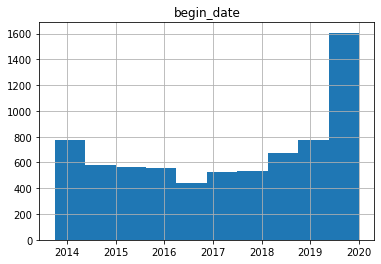

In [2451]:
df_contract.hist('begin_date',bins=10)

Podemos observar una figura en forma de "bañera" que muestra el comportamiento de la apertura de contrato para clientes, iniciando en 2004 con alrededor de 800 contratos abiertos seguido de una caida paulatina hasta llegar a un mínimo en 2016 y 2017 con solamente alrederor de 400 contratos abiertos por año y finalmente una subida en el número de apertura de contratos por año hasta llegar a un máximo de aperturas en 2020 con 1600 aproximadamente.

No                     5163
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: end_date, dtype: int64


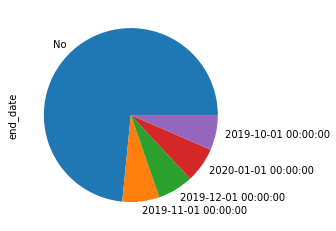

In [2452]:
df_contract['end_date'].value_counts().plot(kind='pie')
print(df_contract['end_date'].value_counts())

Podemos observar que la mayoría de los contratos (73%) aún permanecen abiertos y solamente un pequeño porcentaje han sido cerrados en 2019 (13.5%) y otro tanto en 2020 (6.5%).

Porcentaje de contratos: 
 Month-to-month    0.551052
Two year          0.239619
One year          0.209329
Name: type, dtype: float64


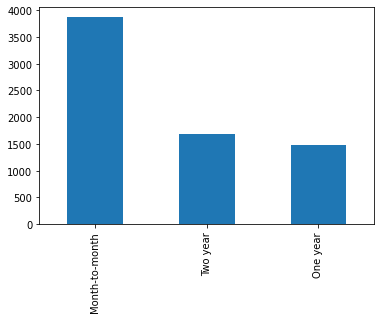

In [2453]:
df_contract['type'].value_counts().plot(kind='bar')
print('Porcentaje de contratos:', '\n', df_contract['type'].value_counts() / df_contract['type'].value_counts().sum())

De todos los contratos abiertos, el 55% pertenecen a contratos con renovación mensual, el 24% pertenece a contrato por dos años, y el 21% pertenece a contrato por año.

Porcentaje de contratos: 
 Yes    0.592719
No     0.407281
Name: paperless_billing, dtype: float64


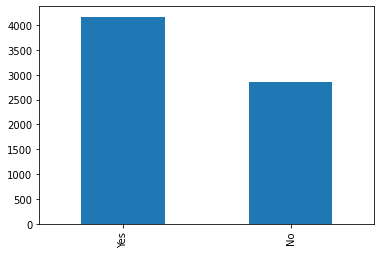

In [2454]:
df_contract['paperless_billing'].value_counts().plot(kind='bar')
print('Porcentaje de contratos:', '\n', df_contract['paperless_billing'].value_counts() / df_contract['paperless_billing'].value_counts().sum())

El 59% de los contratos ha suscrito no recibir más estados de cuenta en papel a domicilio, y el resto aún recibe el estado de cuenta en papel a domicilio.

Porcentaje de contratos: 
 Electronic check             0.336320
Mailed check                 0.228100
Bank transfer (automatic)    0.219283
Credit card (automatic)      0.216297
Name: payment_method, dtype: float64


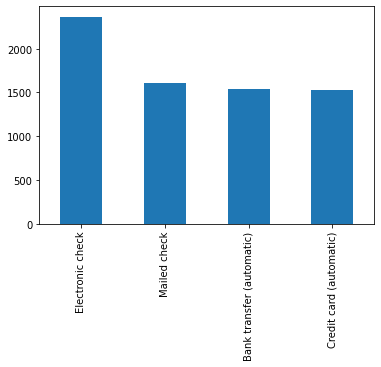

In [2455]:
df_contract['payment_method'].value_counts().plot(kind='bar')
print('Porcentaje de contratos:', '\n', df_contract['payment_method'].value_counts() / df_contract['payment_method'].value_counts().sum())

El 33% de los contratos es pagado electrónicamente, un 23% es pagado por correo,  el 22% realiza transferencia bancaria domiciliada automáticamente, y el 22% restante recibe un cargo a su tarjeta recurrente de manera automática.

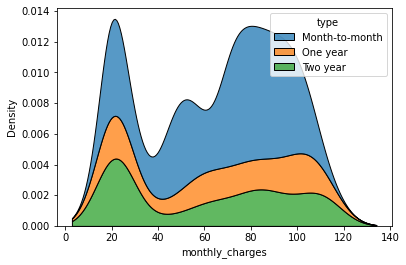

In [2456]:
#df_contract.groupby('type').hist('monthly_charges',bins=10)
sns.kdeplot(data=df_contract, x="monthly_charges", hue="type",multiple="stack")
plt.show()

Acá podemos observar que en general todos los clientes tienen un grupo que paga alrededor de 20 dólares mensuales, sin embargo existen quizá dos o tres grupos que llegan a pagar 60, 80 y 00 dólares por mes. Esto se observa en los diferentes picos que las tres distribuciones muestran. Sin embargo, es el grupo de clientes que pagan mes con mes, el más numeroso, y además quien más clientes tienen con pagos que exceden los 20 dólares mensuales.

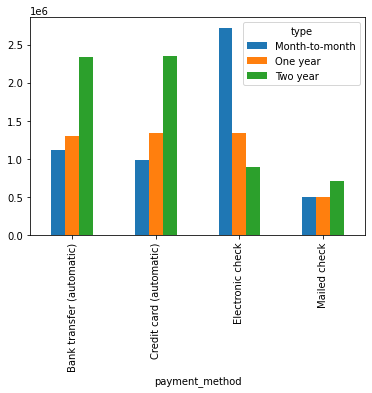

In [2457]:
df_contract.pivot_table(values='total_charges', index = 'payment_method', columns = 'type', aggfunc ='sum').plot(kind='bar')
plt.show()

Acá podemos observar que los clientes con la renovación de contrato mensual tienen la mayor suma de pagos, con la mayor cantidad de pagos acumulados en aquellos que pagan de manera electrónica. También podemos observar que los clientes con contrato a dos años son los que más utilizan transferencia bancaria y tarjeta de crédito.

<AxesSubplot:xlabel='total_charges', ylabel='Density'>

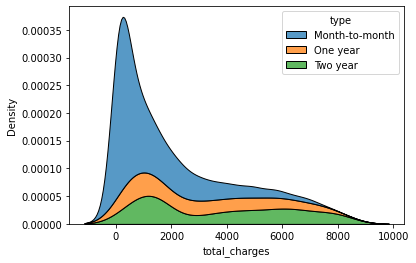

In [2458]:
sns.kdeplot(data=df_contract, x="total_charges", hue="type",multiple="stack")

Aquí podemos observar que existe un largo rango de cargos mensuales para los tres tipos de contratos, siendo aprox 1000 el cargo total más recurrente para los tres, sin embargo, es observable que podemos observar en los tres casos rangos de cargos mensuales tan grandes como los 10,000.

#### Preprocesamiento del Dataframe "Personal"

In [2459]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [2460]:
df_personal.sample()

,customerID,gender,SeniorCitizen,Partner,Dependents
3439,0917-EZOLA,Male,1,Yes,No


In [2461]:
df_personal.columns = ['customer_ID','gender','senior_citizen','partner','dependents']

In [2462]:
df_personal.isna().sum()

customer_ID       0
gender            0
senior_citizen    0
partner           0
dependents        0
dtype: int64

In [2463]:
df_personal[df_personal.duplicated()].count()

customer_ID       0
gender            0
senior_citizen    0
partner           0
dependents        0
dtype: int64

In [2464]:
df_personal.shape

(7043, 5)

#### Análisis exploratorio de datos para "Personal"

In [2465]:
unique_personal = len(df_personal['customer_ID'].unique())
print(unique_personal)

7043


Porcentaje de clientes: 
 Male      0.504756
Female    0.495244
Name: gender, dtype: float64


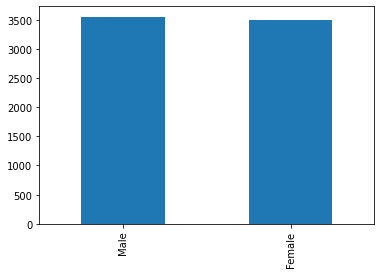

In [2466]:
df_personal['gender'].value_counts().plot(kind='bar')

print('Porcentaje de clientes:', '\n', df_personal['gender'].value_counts() / df_personal['gender'].value_counts().sum())

Podemos observar una distribución igualitaria entre clientes de ambos géneros.

Porcentaje de clientes: 
 0    0.837853
1    0.162147
Name: senior_citizen, dtype: float64


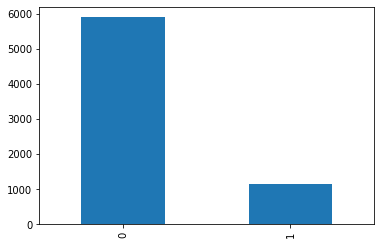

In [2467]:
df_personal['senior_citizen'].value_counts().plot(kind='bar')
print('Porcentaje de clientes:', '\n', df_personal['senior_citizen'].value_counts() / df_personal['senior_citizen'].value_counts().sum())

El 84% de los clientes son considerados por debajo del rango de edad senior, solamente el 16% son considerados senior.

Porcentaje de clientes: 
 No     0.516967
Yes    0.483033
Name: partner, dtype: float64


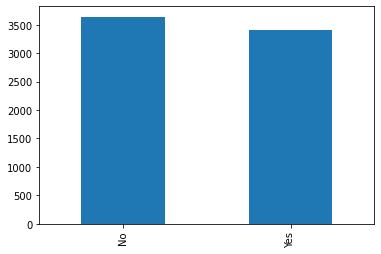

In [2468]:
df_personal['partner'].value_counts().plot(kind='bar')
print('Porcentaje de clientes:', '\n', df_personal['partner'].value_counts() / df_personal['partner'].value_counts().sum())

Tenemos una distribución igual entre clientes que no son solteros o tienen pareja y aquellos que lo son.

Porcentaje de clientes: 
 No     0.700412
Yes    0.299588
Name: dependents, dtype: float64


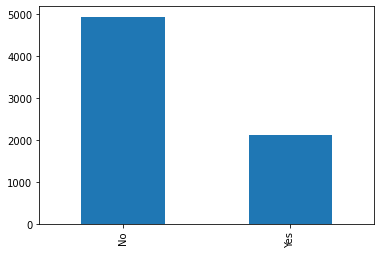

In [2469]:
df_personal['dependents'].value_counts().plot(kind='bar')
print('Porcentaje de clientes:', '\n', df_personal['dependents'].value_counts() / df_personal['dependents'].value_counts().sum())

El 70% de los clientes no tienen dependientes, el 30% de ellos los tiene.

#### Preprocesamiento para Dataframe "Internet"

In [2470]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [2471]:
df_internet.sample()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
4805,3427-GGZZI,Fiber optic,No,Yes,No,No,No,Yes


In [2472]:
df_internet.columns = ['customer_ID','internet_service','online_security','online_backup','device_protection','tech_support','streaming_TV','streaming_movies']

In [2473]:
df_internet.isna().sum()

customer_ID          0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_TV         0
streaming_movies     0
dtype: int64

In [2474]:
df_internet[df_internet.duplicated()].count()

customer_ID          0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_TV         0
streaming_movies     0
dtype: int64

In [2475]:
df_internet.shape

(5517, 8)

#### Análisis exploratorio de datos para  "Internet"

In [2476]:
unique_internet = len(df_internet['customer_ID'].unique())
print(unique_internet)

5517


Porcentaje de usuarios: 
 Fiber optic    0.561175
DSL            0.438825
Name: internet_service, dtype: float64


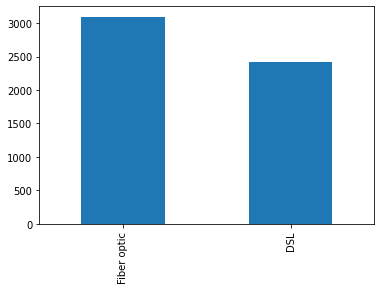

In [2477]:
df_internet['internet_service'].value_counts().plot(kind='bar')
print('Porcentaje de usuarios:', '\n', df_internet['internet_service'].value_counts() / df_internet['internet_service'].value_counts().sum())

El 56% de los usuarios usan el servicio de configuración de red a través de fibra óptica, el 43% usa una línea telefónica o DSL.

Porcentaje de usuarios: 
 No     0.63404
Yes    0.36596
Name: online_security, dtype: float64


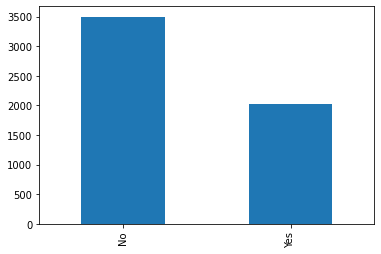

In [2478]:
df_internet['online_security'].value_counts().plot(kind='bar')
print('Porcentaje de usuarios:', '\n', df_internet['online_security'].value_counts() / df_internet['online_security'].value_counts().sum())

El 63% de los usuarios no tienen seguridad en línea contratado, el 37% sí la tiene.

Porcentaje de usuarios: 
 No     0.559724
Yes    0.440276
Name: online_backup, dtype: float64


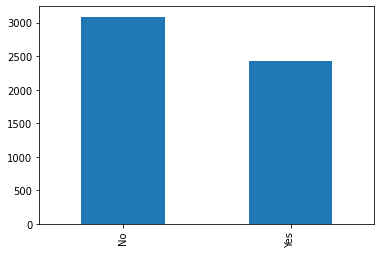

In [2479]:
df_internet['online_backup'].value_counts().plot(kind='bar')
print('Porcentaje de usuarios:', '\n', df_internet['online_backup'].value_counts() / df_internet['online_backup'].value_counts().sum())

El 56% de los usuarios no tienen respaldo en línea contratado, el 44% sí lo tiene.

Porcentaje de usuarios: 
 No     0.560993
Yes    0.439007
Name: device_protection, dtype: float64


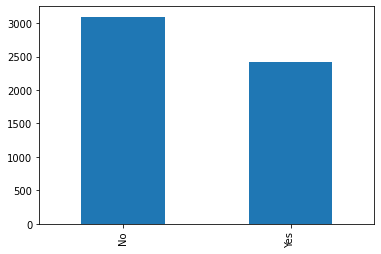

In [2480]:
df_internet['device_protection'].value_counts().plot(kind='bar')
print('Porcentaje de usuarios:', '\n', df_internet['device_protection'].value_counts() / df_internet['device_protection'].value_counts().sum())

El 56% de los usuarios no tienen protección de dispositivo contratado, el 44% sí lo tiene.

Porcentaje de usuarios: 
 No     0.629509
Yes    0.370491
Name: tech_support, dtype: float64


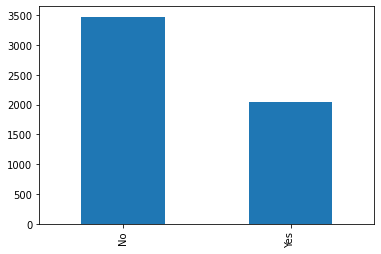

In [2481]:
df_internet['tech_support'].value_counts().plot(kind='bar')
print('Porcentaje de usuarios:', '\n', df_internet['tech_support'].value_counts() / df_internet['tech_support'].value_counts().sum())

El 63% de los usuarios no tienen soporte técnico contratado, el 37% sí lo tiene.

Porcentaje de usuarios: 
 No     0.509335
Yes    0.490665
Name: streaming_TV, dtype: float64


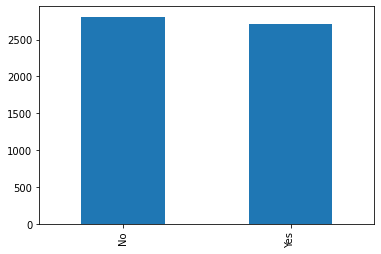

In [2482]:
df_internet['streaming_TV'].value_counts().plot(kind='bar')
print('Porcentaje de usuarios:', '\n', df_internet['streaming_TV'].value_counts() / df_internet['streaming_TV'].value_counts().sum())

El 51% de los usuarios no tienen streaming de TV contratado, el 49% sí lo tiene.

Porcentaje de usuarios: 
 No     0.504803
Yes    0.495197
Name: streaming_movies, dtype: float64


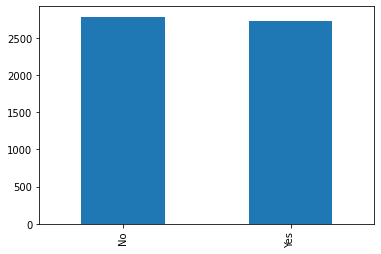

In [2483]:
df_internet['streaming_movies'].value_counts().plot(kind='bar')
print('Porcentaje de usuarios:', '\n', df_internet['streaming_movies'].value_counts() / df_internet['streaming_movies'].value_counts().sum())

El 51% de los usuarios no tienen streaming de películas contratado, el 49% sí lo tiene.

#### Preprocesamiento para Dataframe "Phone"

In [2484]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [2485]:
df_phone.sample()

,customerID,MultipleLines
4123,4355-HBJHH,Yes


In [2486]:
df_phone.columns = ['customer_ID','multiple_lines']

In [2487]:
df_phone.isna().sum()

customer_ID       0
multiple_lines    0
dtype: int64

In [2488]:
df_phone[df_phone.duplicated()].count()

customer_ID       0
multiple_lines    0
dtype: int64

In [2489]:
df_phone.shape

(6361, 2)

#### Análisis exploratorio de datos para "Phone"

In [2490]:
unique_phone = len(df_phone['customer_ID'].unique())
print(unique_phone)

6361


Porcentaje de usuarios: 
 No     0.532935
Yes    0.467065
Name: multiple_lines, dtype: float64


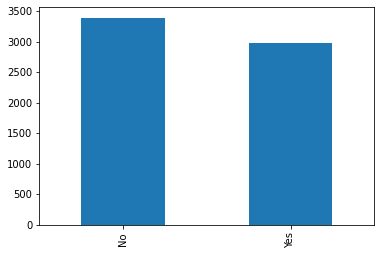

In [2491]:
df_phone['multiple_lines'].value_counts().plot(kind='bar')
print('Porcentaje de usuarios:', '\n', df_phone['multiple_lines'].value_counts() / df_phone['multiple_lines'].value_counts().sum())

El 53% de los usuarios no tienen múltiples líneas contratadas, el 47% sí lo tiene.

### Preguntas aclaratorias

1. ¿Es la separación de servicios contratados de telefonía e internet observada en el EDA consistente para los dos géneros, rango de edad, estado civil y condición de dependientes? Esto es, ¿se repite la misma distribución en cada subgrupo de clientes?  

2. Existe una desconexión entre el número de clientes registrados en los archivos de contrato, internet y telefonía. ¿Es conveniente rellenar los datos faltantes con medias o medianas para los clientes no registrados en los archivos de internet y telefonía? ¿Con qué datos numéricos?

In [2492]:
users_dict = {
    'file': ['personal','contract', 'internet', 'phone'],
        'users': [7043, 7043, 5517, 6361]
} 
users = pd.DataFrame(users_dict)

In [2493]:
users

,file,users
0,personal,7043
1,contract,7043
2,internet,5517
3,phone,6361


3. ¿Cuántos de los IDs de clientes son coincidentes entre los diferentes archivos? ¿Qué resultado tendrá esto cuando se haga la unión de DataFrames?

4. ¿Consideran que Monthly_Charge y Total_Charge son columnas relevantes para determinar los paquetes contratados por los clientes y en en su caso, serán relevantes para determinar la permanencia de los clientes?

### Plan de resolución

- Inicialmente será necesario determinar los IDs de clientes que contienen toda la información disponible para su uso como características de un modelo a entrenar.

- Es necesario discutir cuáles son aquellas características que son de mayor relevancia para determinar la estancia del cliente en la compañia, pensando que el modelo es una clasificación donde 0 es permanencia y 1 es salida.

- Posteriormente, para poder entrenar un modelo de clasificación es necesario hacer una unión de los archivos analizados en uno solo, descartando las columnas y filas que no serán requeridas.

- Será necesario cambiar los datos a clasificación de etiquetas para probar los modelos de clasificación de árbol de decisión y bosque aleatorio, para el modelo de regresión logística se requerirá hacer la codificación de One-Hot. 

- Se entrenaran y validarán al menos tres modelos diferentes utilizando el set de datos de entrenamiento y validación, y se obtendrán las métricas requeridas por el proyecto para determinar cuál es la más óptima.

- Finalmente se utilizará el set de prueba para correr con el modelo entrenado que haya mostrado mejor desempeño con los datos de validación.

### Procesamiento secundario de datos

#### Inicialización de librerías para los modelos de clasificación

In [2494]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#### Unión de los archivos para obtener las características

In [2495]:
merged_df = pd.merge(df_contract, df_personal, on='customer_ID', how='outer')

In [2496]:
merged_df = pd.merge(merged_df, df_internet, on='customer_ID', how='outer')

In [2497]:
merged_df = pd.merge(merged_df, df_phone, on='customer_ID', how='outer')

In [2498]:
merged_df.head()

,customer_ID,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_TV,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [2499]:
merged_df.shape

(7043, 20)

In [2500]:
merged_df.isna().sum()

customer_ID             0
begin_date             11
end_date               11
type                   11
paperless_billing      11
payment_method         11
monthly_charges        11
total_charges          11
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_TV         1526
streaming_movies     1526
multiple_lines        682
dtype: int64

Hasta este punto tenemos un DataFrame unido por Customer_ID con todas las características que consideramos relevantes, esto es:
- type                 
- paperless_billing      
- payment_method                
- gender                  
- senior_citizen          
- partner                 
- dependents              
- internet_service     
- online_security      
- online_backup        
- device_protection    
- tech_support         
- streaming_TV         
- streaming_movies     
- multiple_lines  

A continuación vamos a trabajar con monthly charges, total charges, end date y begin date para que puedan también ser usados como características en el modelo de manera más adecuada. También vamos a crear una columna contract_end que funcione como nuestro target para el modelo.

#### Procesamiento para objetivos y características

##### Monthly charges group

In [2501]:
def monthly_charges_group(row):
    monthly_charges_row = row['monthly_charges']
    
    if monthly_charges_row <= 20:
        return 'a'
    if monthly_charges_row <= 40:
        return 'b'
    if monthly_charges_row <= 60:
        return 'c'
    if monthly_charges_row <= 80:
        return 'd'
    if monthly_charges_row <= 100:
        return 'e'
    if monthly_charges_row <= 120:
        return 'f'

In [2502]:
merged_df['monthly_charges_group'] = merged_df.apply(monthly_charges_group, axis=1)

##### Total charges group

In [2503]:
def total_charges_group(row):
    total_charges_row = row['total_charges']
    
    if total_charges_row <= 2000:
        return 'a'
    if total_charges_row <= 4000:
        return 'b'
    if total_charges_row <= 6000:
        return 'c'
    if total_charges_row <= 8000:
        return 'd'
    if total_charges_row <= 10000:
        return 'e'

In [2504]:
merged_df['total_charges_group'] = merged_df.apply(total_charges_group, axis=1)

In [2505]:
merged_df.head()

,customer_ID,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_TV,streaming_movies,multiple_lines,monthly_charges_group,total_charges_group
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,...,DSL,No,Yes,No,No,No,No,NaN,b,a
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,...,DSL,Yes,No,Yes,No,No,No,No,c,a
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,...,DSL,Yes,Yes,No,No,No,No,No,c,a
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,...,DSL,Yes,No,Yes,Yes,No,No,NaN,c,a
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,...,Fiber optic,No,No,No,No,No,No,No,d,a


##### Begin_date y End_date

In [2506]:
merged_df['begin_year'] = merged_df['begin_date'].dt.year
merged_df['begin_month'] = merged_df['begin_date'].dt.month

##### Contract_end

In [2507]:
merged_df['contract_end'] = merged_df['end_date'].where(merged_df['end_date']=='No','Yes')

##### Valores ausentes

A continuación, he decidido adoptar una estrategia de relleno de valores ausentes que privilegie el grupo de cargo mensual y el tipo de contrato para rellenar los ausentes de servicio en donde éstos se requieran, esto en acuerdo con el EDA inicial en donde se observó que el cargo mensual cubre un amplio espectro mientras que los servicios están divididos de manera binaria en porcentajes similares. Por ejemplo, para rellenar internet service, los datos me indican que el plan a tiende a ser solamente DSL, mientras que el plan b en adelante son de fibra óptica.

Esta estrategia me parece conveniente porque también se evita el sesgo de asignar un valor de relleno basado en el género, seniority, partnership y dependents. Los cuales no son definitorios para predecir el tipo de servicio que contrata el usuario donde los datos son faltantes.

In [2508]:
merged_df['internet_service'].fillna('unknown',inplace=True)
merged_df['online_security'].fillna('unknown',inplace=True)
merged_df['online_backup'].fillna('unknown',inplace=True)
merged_df['device_protection'].fillna('unknown',inplace=True)
merged_df['tech_support'].fillna('unknown',inplace=True)
merged_df['streaming_TV'].fillna('unknown',inplace=True)
merged_df['streaming_movies'].fillna('unknown',inplace=True)
merged_df['multiple_lines'].fillna('unknown',inplace=True)

In [2509]:
pivot_table_internet = merged_df.pivot_table(values='customer_ID',index=['monthly_charges_group','type'],columns=['internet_service'],aggfunc='count',margins=True)
pivot_table_security = merged_df.pivot_table(values='customer_ID',index=['monthly_charges_group','type'],columns=['online_security'],aggfunc='count',margins=True)
pivot_table_backup = merged_df.pivot_table(values='customer_ID',index=['monthly_charges_group','type'],columns=['online_backup'],aggfunc='count',margins=True)
pivot_table_protection = merged_df.pivot_table(values='customer_ID',index=['monthly_charges_group','type'],columns=['device_protection'],aggfunc='count',margins=True)
pivot_table_support = merged_df.pivot_table(values='customer_ID',index=['monthly_charges_group','type'],columns=['tech_support'],aggfunc='count',margins=True)
pivot_table_streaming_TV = merged_df.pivot_table(values='customer_ID',index=['monthly_charges_group','type'],columns=['streaming_TV'],aggfunc='count',margins=True)
pivot_table_streaming_movies = merged_df.pivot_table(values='customer_ID',index=['monthly_charges_group','type'],columns=['streaming_movies'],aggfunc='count',margins=True)
pivot_table_multiple_lines = merged_df.pivot_table(values='customer_ID',index=['monthly_charges_group','type'],columns=['multiple_lines'],aggfunc='count',margins=True)

In [2510]:
pivot_table_internet

internet_service                         DSL  Fiber optic  unknown   All
monthly_charges_group type                                              
a                     Month-to-month     NaN          NaN    253.0   253
                      One year           NaN          NaN    164.0   164
                      Two year           NaN          NaN    236.0   236
b                     Month-to-month   238.0          NaN    271.0   509
                      One year          46.0          NaN    199.0   245
                      Two year          28.0          NaN    397.0   425
c                     Month-to-month   731.0          NaN      NaN   731
                      One year         213.0          NaN      NaN   213
                      Two year         134.0          NaN      NaN   134
d                     Month-to-month   239.0        678.0      NaN   917
                      One year         266.0         19.0      NaN   285
                      Two year         246.0          9.0      NaN   255
e                     Month-to-month    15.0       1126.0      NaN  1141
                      One year          45.0        247.0      NaN   292
                      Two year         215.0        115.0      NaN   330
f                     Month-to-month     NaN        324.0      NaN   324
                      One year           NaN        273.0      NaN   273
                      Two year           NaN        305.0      NaN   305
All                                   2416.0       3096.0   1520.0  7032

In [2511]:
def replace_internet_service(row):
    
    internet_1=row['internet_service']
    monthly_1=row['monthly_charges_group']
    type_1=row['type']
    
    if internet_1=='unknown' and monthly_1=='a':
        replacement_value= 'DSL'
        return replacement_value
    
    elif internet_1=='unknown' and monthly_1=='b':
        replacement_value= 'Fiber optic'
        return replacement_value

    else:
        return internet_1

In [2512]:
merged_df['internet_service']=merged_df.apply(replace_internet_service,axis=1)

In [2513]:
def replace_online_security(row):
    
    security_1=row['online_security']
    monthly_1=row['monthly_charges_group']
    type_1=row['type']
    
    if security_1=='unknown' and monthly_1=='a':
        replacement_value= 'No'
        return replacement_value
    
    elif security_1=='unknown' and monthly_1=='b':
        replacement_value= 'No'
        return replacement_value
    
    else:
        return security_1

In [2514]:
merged_df['online_security']=merged_df.apply(replace_online_security,axis=1)

In [2515]:
def replace_online_backup(row):
    
    backup_1=row['online_backup']
    monthly_1=row['monthly_charges_group']
    type_1=row['type']
    
    if backup_1=='unknown' and monthly_1=='a':
        replacement_value= 'No'
        return replacement_value
    
    elif backup_1=='unknown' and monthly_1=='b':
        replacement_value= 'No'
        return replacement_value

    else:
        return backup_1

In [2516]:
merged_df['online_backup']=merged_df.apply(replace_online_backup,axis=1)

In [2517]:
def replace_device_protection(row):
    
    protection_1=row['device_protection']
    monthly_1=row['monthly_charges_group']
    type_1=row['type']
    
    if protection_1=='unknown' and monthly_1=='a':
        replacement_value= 'No'
        return replacement_value
    
    elif protection_1=='unknown' and monthly_1=='b':
        replacement_value= 'No'
        return replacement_value

    else:
        return protection_1

In [2518]:
merged_df['device_protection']=merged_df.apply(replace_device_protection,axis=1)

In [2519]:
def replace_tech_support(row):
    
    tech_1=row['tech_support']
    monthly_1=row['monthly_charges_group']
    type_1=row['type']
    
    if tech_1=='unknown' and monthly_1=='a':
        replacement_value= 'No'
        return replacement_value
    
    elif tech_1=='unknown' and monthly_1=='b':
        replacement_value= 'No'
        return replacement_value

    else:
        return tech_1

In [2520]:
merged_df['tech_support']=merged_df.apply(replace_tech_support,axis=1)

In [2521]:
def replace_streaming_TV(row):
    
    TV_1=row['streaming_TV']
    monthly_1=row['monthly_charges_group']
    type_1=row['type']
    
    if TV_1=='unknown' and monthly_1=='a':
        replacement_value= 'No'
        return replacement_value
    
    elif TV_1=='unknown' and monthly_1=='b':
        replacement_value= 'Yes'
        return replacement_value

    else:
        return TV_1

In [2522]:
merged_df['streaming_TV']=merged_df.apply(replace_streaming_TV,axis=1)

In [2523]:
def replace_streaming_movies(row):
    
    movies_1=row['streaming_movies']
    monthly_1=row['monthly_charges_group']
    type_1=row['type']
    
    if movies_1=='unknown' and monthly_1=='a':
        replacement_value= 'No'
        return replacement_value
    
    elif movies_1=='unknown' and monthly_1=='b':
        replacement_value= 'Yes'
        return replacement_value

    else:
        return movies_1

In [2524]:
merged_df['streaming_movies']=merged_df.apply(replace_streaming_movies,axis=1)

In [2525]:
def replace_multiple_lines(row):
    
    multiple_1=row['multiple_lines']
    monthly_1=row['monthly_charges_group']
    type_1=row['type']
    
    if multiple_1=='unknown' and monthly_1=='b':
        replacement_value= 'No'
        return replacement_value
    
    elif multiple_1=='unknown' and monthly_1=='c':
        replacement_value= 'No'
        return replacement_value
    
    elif multiple_1=='unknown' and monthly_1=='d':
        replacement_value= 'Yes'
        return replacement_value

    else:
        return multiple_1

In [2526]:
merged_df['multiple_lines']=merged_df.apply(replace_multiple_lines,axis=1)

In [2527]:
merged_df=merged_df.dropna().reset_index(drop=True)

In [2528]:
merged_df.isna().sum()

customer_ID              0
begin_date               0
end_date                 0
type                     0
paperless_billing        0
payment_method           0
monthly_charges          0
total_charges            0
gender                   0
senior_citizen           0
partner                  0
dependents               0
internet_service         0
online_security          0
online_backup            0
device_protection        0
tech_support             0
streaming_TV             0
streaming_movies         0
multiple_lines           0
monthly_charges_group    0
total_charges_group      0
begin_year               0
begin_month              0
contract_end             0
dtype: int64

In [2529]:
merged_df[merged_df=='unknown'].count()

customer_ID              0
begin_date               0
end_date                 0
type                     0
paperless_billing        0
payment_method           0
monthly_charges          0
total_charges            0
gender                   0
senior_citizen           0
partner                  0
dependents               0
internet_service         0
online_security          0
online_backup            0
device_protection        0
tech_support             0
streaming_TV             0
streaming_movies         0
multiple_lines           0
monthly_charges_group    0
total_charges_group      0
begin_year               0
begin_month              0
contract_end             0
dtype: int64

In [2530]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   customer_ID            7032 non-null   object        
 1   begin_date             7032 non-null   datetime64[ns]
 2   end_date               7032 non-null   object        
 3   type                   7032 non-null   object        
 4   paperless_billing      7032 non-null   object        
 5   payment_method         7032 non-null   object        
 6   monthly_charges        7032 non-null   float64       
 7   total_charges          7032 non-null   float64       
 8   gender                 7032 non-null   object        
 9   senior_citizen         7032 non-null   int64         
 10  partner                7032 non-null   object        
 11  dependents             7032 non-null   object        
 12  internet_service       7032 non-null   object        
 13  onl

Con este trabajo hemos podido rescatar la mayor cantidad de datos ausentes en el DataFrame unido, con una pérdida minima respecto a los DF originales, esto es, nos hemos quedado con un DF de 7032 datapoints de 7043 datapoints que teníamos inicialmente. Esto evitando sesgar los datos de manera que afecte la distribución de los datos entre los usuarios como se puede apreciar en el siguiente gráfico.

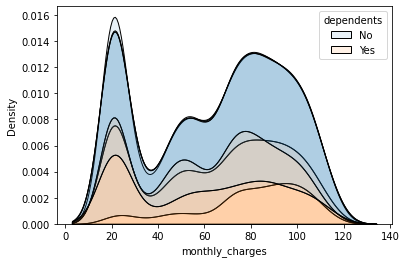

In [2531]:
sns.kdeplot(data=merged_df, x="monthly_charges", hue="gender",multiple="stack",alpha=0.1)
sns.kdeplot(data=merged_df, x="monthly_charges", hue="senior_citizen",multiple="stack",alpha=0.1)
sns.kdeplot(data=merged_df, x="monthly_charges", hue="partner",multiple="stack",alpha=0.1)
sns.kdeplot(data=merged_df, x="monthly_charges", hue="dependents",multiple="stack",alpha=0.1)
plt.show()

### Procesamiento terciario de datos

#### Conversión a datos ordinales

In [2532]:
data_non_numeric = merged_df.loc[:,['type','paperless_billing','payment_method','gender','partner','dependents','internet_service','online_security','online_backup','device_protection','tech_support','streaming_TV','streaming_movies','multiple_lines','monthly_charges_group','total_charges_group','begin_year','begin_month','contract_end']]

In [2533]:
encoder = OrdinalEncoder()
data_ordinal = pd.DataFrame(encoder.fit_transform(data_non_numeric), columns=data_non_numeric.columns)

In [2534]:
merged_df['type_ord'] = data_ordinal['type']
merged_df['paperless_billing_ord'] = data_ordinal['paperless_billing']
merged_df['payment_method_ord'] = data_ordinal['payment_method']
merged_df['gender_ord'] = data_ordinal['gender']
merged_df['partner_ord'] = data_ordinal['partner']
merged_df['dependents_ord'] = data_ordinal['dependents']
merged_df['internet_service_ord'] = data_ordinal['internet_service']
merged_df['online_security_ord'] = data_ordinal['online_security']
merged_df['online_backup_ord'] = data_ordinal['online_backup']
merged_df['device_protection_ord'] = data_ordinal['device_protection']
merged_df['tech_support_ord'] = data_ordinal['tech_support']
merged_df['streaming_TV_ord'] = data_ordinal['streaming_TV']
merged_df['streaming_movies_ord'] = data_ordinal['streaming_movies']
merged_df['multiple_lines_ord'] = data_ordinal['multiple_lines']
merged_df['monthly_charges_group_ord'] = data_ordinal['monthly_charges_group']
merged_df['total_charges_group_ord'] = data_ordinal['total_charges_group']
merged_df['begin_year_ord'] = data_ordinal['begin_year']
merged_df['begin_month_ord'] = data_ordinal['begin_month']
merged_df['contract_end_ord'] = data_ordinal['contract_end']

In [2535]:
merged_df.columns

Index(['customer_ID', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_TV', 'streaming_movies', 'multiple_lines',
       'monthly_charges_group', 'total_charges_group', 'begin_year',
       'begin_month', 'contract_end', 'type_ord', 'paperless_billing_ord',
       'payment_method_ord', 'gender_ord', 'partner_ord', 'dependents_ord',
       'internet_service_ord', 'online_security_ord', 'online_backup_ord',
       'device_protection_ord', 'tech_support_ord', 'streaming_TV_ord',
       'streaming_movies_ord', 'multiple_lines_ord',
       'monthly_charges_group_ord', 'total_charges_group_ord',
       'begin_year_ord', 'begin_month_ord', 'contract_end_ord'],
      dtype='object')

In [2536]:
data_for_model = merged_df.drop(['customer_ID','begin_date','end_date','type','paperless_billing','payment_method','monthly_charges','total_charges','gender','partner','dependents','internet_service','online_security','online_backup','device_protection','tech_support','streaming_TV','streaming_movies','multiple_lines','monthly_charges_group','total_charges_group','begin_year','begin_month','contract_end'], axis=1)

In [2537]:
data_for_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   senior_citizen             7032 non-null   int64  
 1   type_ord                   7032 non-null   float64
 2   paperless_billing_ord      7032 non-null   float64
 3   payment_method_ord         7032 non-null   float64
 4   gender_ord                 7032 non-null   float64
 5   partner_ord                7032 non-null   float64
 6   dependents_ord             7032 non-null   float64
 7   internet_service_ord       7032 non-null   float64
 8   online_security_ord        7032 non-null   float64
 9   online_backup_ord          7032 non-null   float64
 10  device_protection_ord      7032 non-null   float64
 11  tech_support_ord           7032 non-null   float64
 12  streaming_TV_ord           7032 non-null   float64
 13  streaming_movies_ord       7032 non-null   float

In [2538]:
data_for_model.head()

,senior_citizen,type_ord,paperless_billing_ord,payment_method_ord,gender_ord,partner_ord,dependents_ord,internet_service_ord,online_security_ord,online_backup_ord,device_protection_ord,tech_support_ord,streaming_TV_ord,streaming_movies_ord,multiple_lines_ord,monthly_charges_group_ord,total_charges_group_ord,begin_year_ord,begin_month_ord,contract_end_ord
0,0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7.0,0.0,0.0
1,0,1.0,0.0,3.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,4.0,3.0,0.0
2,0,0.0,1.0,3.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,6.0,9.0,1.0
3,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,3.0,4.0,0.0
4,0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,6.0,8.0,1.0


#### Tratamiento de datos categóricos con OHE

In [2539]:
merged_OHE = merged_df.loc[:,'type':'contract_end_ord']
data_for_OHE = merged_OHE.drop(['monthly_charges','total_charges','contract_end', 'type_ord', 'paperless_billing_ord',
       'payment_method_ord', 'gender_ord', 'partner_ord', 'dependents_ord',
       'internet_service_ord', 'online_security_ord', 'online_backup_ord',
       'device_protection_ord', 'tech_support_ord', 'streaming_TV_ord',
       'streaming_movies_ord', 'multiple_lines_ord',
       'monthly_charges_group_ord', 'total_charges_group_ord',
       'begin_year_ord', 'begin_month_ord'],axis=1)

In [2540]:
data_for_OHE.columns

Index(['type', 'paperless_billing', 'payment_method', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_TV', 'streaming_movies', 'multiple_lines',
       'monthly_charges_group', 'total_charges_group', 'begin_year',
       'begin_month', 'contract_end_ord'],
      dtype='object')

In [2541]:
data_for_reg = pd.get_dummies(data_for_OHE, drop_first=True)

In [2542]:
data_for_reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 30 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   senior_citizen                          7032 non-null   int64  
 1   begin_year                              7032 non-null   float64
 2   begin_month                             7032 non-null   float64
 3   contract_end_ord                        7032 non-null   float64
 4   type_One year                           7032 non-null   uint8  
 5   type_Two year                           7032 non-null   uint8  
 6   paperless_billing_Yes                   7032 non-null   uint8  
 7   payment_method_Credit card (automatic)  7032 non-null   uint8  
 8   payment_method_Electronic check         7032 non-null   uint8  
 9   payment_method_Mailed check             7032 non-null   uint8  
 10  gender_Male                             7032 non-null   uint

In [2543]:
data_for_reg.head()

,senior_citizen,begin_year,begin_month,contract_end_ord,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,...,multiple_lines_Yes,monthly_charges_group_b,monthly_charges_group_c,monthly_charges_group_d,monthly_charges_group_e,monthly_charges_group_f,total_charges_group_b,total_charges_group_c,total_charges_group_d,total_charges_group_e
0,0,2020.0,1.0,0.0,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0
1,0,2017.0,4.0,0.0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
2,0,2019.0,10.0,1.0,0,0,1,0,0,1,...,0,0,1,0,0,0,0,0,0,0
3,0,2016.0,5.0,0.0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,2019.0,9.0,1.0,0,0,1,0,1,0,...,0,0,0,1,0,0,0,0,0,0


### División de los sets de entrenamiento, validación y prueba

#### Sets para árbol de decisión y bosque aleatorio

In [2544]:
target = data_for_model['contract_end_ord']
features = data_for_model.drop('contract_end_ord', axis=1)

In [2545]:
X_train, X_valid_test, Y_train, Y_valid_test = train_test_split(features, target, test_size=0.4, random_state=12345)
X_valid, X_test, Y_valid, Y_test = train_test_split(X_valid_test, Y_valid_test, test_size=0.5, random_state=12345)

#### Sets para regresión logística

In [2546]:
target_1 = data_for_reg['contract_end_ord']
features_1 = data_for_reg.drop('contract_end_ord', axis=1)

In [2547]:
X_train_1, X_valid_test_1, Y_train_1, Y_valid_test_1 = train_test_split(features_1, target_1, test_size=0.4, random_state=12345)
X_valid_1, X_test_1, Y_valid_1, Y_test_1 = train_test_split(X_valid_test_1, Y_valid_test_1, test_size=0.5, random_state=12345)

### Entrenamiento y evaluación de desempeño

#### AUC_ROC - árbol de decisión

In [2548]:
best_AUC_ROC = 0
best_depth = 0
for depth in range(1, 20):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_valid)
    AUC_ROC = round(roc_auc_score(Y_valid, Y_pred),2)
    if AUC_ROC > best_AUC_ROC:
        best_AUC_ROC = AUC_ROC
        best_depth = depth
print("Best AUC-ROC (max_depth = {}): {}".format(best_depth, best_AUC_ROC))

Best AUC-ROC (max_depth = 9): 0.7


#### AUC_ROC - bosque aleatorio

In [2549]:
best_AUC_ROC = 0
best_est = 0
best_depth = 0
for depth in range(1, 20):
    for est in range(10, 50,10):
        model = RandomForestClassifier(random_state=54321, n_estimators=est, max_depth=depth)
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_valid)
        AUC_ROC = round(roc_auc_score(Y_valid, Y_pred),2)
        if AUC_ROC > best_AUC_ROC:
            best_AUC_ROC = AUC_ROC
            best_est = est
            best_depth = depth
print("Best AUC-ROC (n_estimators = {}, max_depth = {}): {}".format(best_est, best_depth, best_AUC_ROC))

Best AUC-ROC (n_estimators = 20, max_depth = 10): 0.74


#### AUC_ROC - regresión logística

In [2550]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(X_train_1, Y_train_1)
Y_pred_1 = model.predict(X_valid_1)
print("AUC-ROC: ",round(roc_auc_score(Y_valid_1, Y_pred_1),2))

AUC-ROC:  0.71


### Verificación del mejor modelo con el set de prueba

In [2551]:
model_test = RandomForestClassifier(random_state=54321, n_estimators=20, max_depth=10)
model_test.fit(X_train, Y_train)

RandomForestClassifier(max_depth=10, n_estimators=20, random_state=54321)

In [2552]:
probabilities_test = model_test.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(Y_test, probabilities_one_test)
print('Métrica AUC-ROC con el conjunto de prueba:', round(auc_roc,2))

Métrica AUC-ROC con el conjunto de prueba: 0.83


In [2553]:
probabilities_test[:, 0].mean()

0.7354215754202589

In [2554]:
probabilities_test[:, 1].mean()

0.2645784245797411

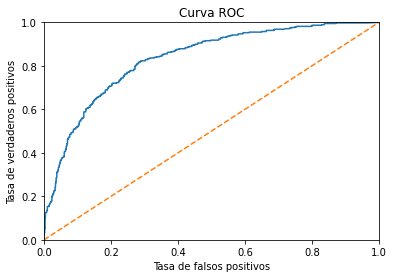

In [2555]:
fpr, tpr, thresholds = roc_curve(Y_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.show()

### Conclusiones sobre el entrenamiento y validación de los modelos

- Se realizó la conversión de datos categóricos a ordinales para su uso en los modelos de árbol de decisión y bosque. así mismo, se realizó el tratamiento de datos categóricos con One Hot End para su uso en el modelo de regresión logística.

- Posteriormente se llevo a cabo la división de los sets de entrenamiento, validación y prueba, siguiendo una comvención de 3:1:1 o bien, 60-60-20.

- El entrenamiento de árbol de decisión se realizó modificando el hiperparámetro de profundidad para encontrar la métrica más alta disponible. Igualmente, para bosque aleatorio se entreno el modelo con el hiperparámetro de profundidad y estimadores correspondientes. Finalmente se entreno el modelo de regresión logística.

- El modelo con la métrica de área bajo la curva de características operativas más alta resultó ser el bosque aleatorio con 0.74, seguido de árbol de regresión logística con 0.71 y finalmente árbol de decisión con 0.7. Lo que significa que el modelo de bosque aleatorio tiene el mejor rendimiento en todos los umbrales de clasificación posibles. O bien, este modelo tiene una probabilidad más alta de clasificar un valor positivo aleatorio que un valor negativo aleatorio como resultado dados los inputs del modelo. 

- Finalmente, con el modelo de bosque aleatorio, se realizó el cálculo de probabilidad de obtener resultado 0 y resultado 1 para 1407 datos del conjunto de prueba, dando como resultado una probabilidad media de obtener resultados igual a 0 del 73% y 26% para resultados igual a 1. Resultando en una métrica de AUC_ROC para el set de prueba de 0.83, que es la probabilidad agregada de clasificar un valor positivo aleatorio. Se agrega el gráfico que muestra la línea de umbral entre la tasa de falsos positivos y la tasa de verdaderos positivos en la que se puede observar que por encima de una tasa de 0.83 de falsos positivos se obtienen 100% de verdaderos positivos en el modelo.